In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("../..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
import jax_smi
jax_smi.initialise_tracking()
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2-2b-it.gguf",
                                         from_type="gemma2",
                                         load_eager=True
                                         )

KeyboardInterrupt: 

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
from sprint.icl_sfc_utils import Circuitizer

In [6]:
from sprint.task_vector_utils import load_tasks, ICLRunner
tasks = load_tasks()

In [23]:
task_names = list(tasks.keys())
# task_name = task_names[1]

In [19]:
import json

use_65k = True

if use_65k:
    file_name = "gemma_2_cleaning_compact_65k.jsonl"
else:
    file_name = "gemma_2_cleaning_compact.jsonl"

with open(file_name) as f:
    lines = f.readlines()
    results = [json.loads(line) for line in lines]

In [9]:
import jax.numpy as jnp
import jax


from sprint.task_vector_utils import ICLRunner, logprob_loss, get_tv, make_act_adder
from micrlhf.llama import LlamaBlock
from micrlhf.sampling import sample, jit_wrapper


get_resids = llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(lambda i, x:
    pz.nn.Sequential([
        pz.de.TellIntermediate.from_config(tag=f"resid_pre_{i}"),
        x
    ])
)
get_resids = pz.de.CollectingSideOutputs.handling(get_resids, tag_predicate=lambda x: x.startswith("resid_pre"))
get_resids_call = jit_wrapper.Jitted(get_resids)



def tokenized_to_inputs(input_ids, attention_mask):
    token_array = jnp.asarray(input_ids)
    token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")

    mask_array = jnp.asarray(attention_mask, dtype=jnp.bool)
    mask_array = jax.device_put(mask_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    mask_array = pz.nx.wrap(mask_array, "batch", "seq").untag("batch").tag("batch")

    inputs = llama.inputs.from_basic_segments(token_array)
    return inputs


In [13]:
from sprint.icl_sfc_utils import AblatedModule
layer = 18
mask_name = "arrow"

In [24]:
import numpy as np
from micrlhf.utils.load_sae import get_dm_res_sae

features = []

sae = get_dm_res_sae(layer, load_65k=use_65k)
threshold = sae.get("threshold", 0)

for task_name in task_names:
    task_results = [result for result in results if result["task"] == task_name and result["layer"] == layer]

    for result in task_results:
        features += result["indices"]

features = list(set(features))

len(features)

102

In [68]:
import dataclasses
from tqdm.auto import tqdm
from functools import partial
from micrlhf.utils.activation_manipulation import add_vector

task_losses_positive = {}

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "<start_of_turn>user\nFollow the pattern:\n{}"

def make_taker(llama, layer):
    taker = jit_wrapper.Jitted(llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(
        lambda i, x: x if i >= layer else pz.nn.Identity()
    ).select().at_instances_of(pz.nn.EmbeddingLookup).apply(lambda _: pz.nn.Identity())
                    .select().at_instances_of(pz.nn.ConstantRescale).pick_nth_selected(0).apply(lambda _: pz.nn.Identity()))

    return taker

taker = make_taker(llama, layer)

for task_name in tqdm(task_names):

    sep = 3978
    pad = 0


    pairs = list(tasks[task_name].items())

    n_shot = n_few_shots - 1
    if task_name.startswith("algo"):
        n_shot = 8

    runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=1, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

    tokenized = runner.get_tokens([
        x[:n_few_shots] for x in runner.train_pairs
    ], tokenizer)

    inputs = tokenized_to_inputs(**tokenized)
    train_tokens = tokenized["input_ids"]

    _, all_resids = get_resids_call(inputs)

    scale = 60

    resids = all_resids[layer].value.unwrap("batch", "seq", "embedding")

    mask = train_tokens == sep
    col_indices = jnp.arange(mask.shape[1])
    col_indices_broadcasted = mask * col_indices
    sorted_indices = jnp.sort(col_indices_broadcasted, axis=1, descending=True)
    positions = sorted_indices[:, :1]
    
    def steer_with_direction(direction):
        direction = direction / jnp.linalg.norm(direction)
        direction = direction * scale
        
        modified = jax.vmap(lambda a, b: a.at[b].add(direction))(
            resids, positions
        )
        modified = pz.nx.wrap(modified, "batch", "seq", "embedding")

        _inputs = dataclasses.replace(inputs, tokens=modified)
        logits = taker(_inputs).unwrap("batch", "seq", "vocabulary")

        return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2)

    task_losses_positive[task_name] = [[steer_with_direction(sae["W_dec"][feature]).tolist() for feature in tqdm(features)]]

    logits = llama(inputs)

    logits = logits.unwrap("batch", "seq", "vocabulary")

    task_losses_positive[task_name].append(logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2).tolist())

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



In [117]:
import dataclasses
from tqdm.auto import tqdm
from functools import partial
from micrlhf.utils.activation_manipulation import add_vector

negative_task_losses = {}

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "<start_of_turn>user\nFollow the pattern:\n{}"

def calc_acc(tokens, sep, logits, runner):
    arrow_pos = jnp.nonzero(tokens == sep)
    arrow_pos_single = []
    for i in range(batch_size):
        arrow_pos_single.append(arrow_pos[1][arrow_pos[0] == i].max())

    arrow_pos_single = np.array(arrow_pos_single)

    hits = 0

    for i, (ap, l) in enumerate(zip(arrow_pos_single, logits)):
        l = l.argmax(-1)
        tgt = runner.eval_pairs[i][-1][1]
        hits += int(tgt in repr(tokenizer.decode(l[ap:ap+3])))
    return hits / runner.eval_batch_size

def calc_acc(tokens, sep, logits, runner):
    logits = logits.argmax(-1)
    logits = logits[:, :-1]
    tokens = tokens[:, 1:]

    mask = tokens == sep

    hits = tokens == logits

    hits = hits * mask

    hits = hits.sum()
    return hits / mask.sum()




def make_taker(llama, layer):
    taker = jit_wrapper.Jitted(llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(
        lambda i, x: x if i >= layer else pz.nn.Identity()
    ).select().at_instances_of(pz.nn.EmbeddingLookup).apply(lambda _: pz.nn.Identity())
                    .select().at_instances_of(pz.nn.ConstantRescale).pick_nth_selected(0).apply(lambda _: pz.nn.Identity()))

    return taker

taker = make_taker(llama, layer)

for task_name in tqdm(task_names):

    sep = 3978
    pad = 0


    pairs = list(tasks[task_name].items())

    n_shot = n_few_shots - 1
    if task_name.startswith("algo"):
        n_shot = 16

    runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

    tokenized = runner.get_tokens([
        x[:n_few_shots] for x in runner.train_pairs
    ], tokenizer)

    inputs = tokenized_to_inputs(**tokenized)
    train_tokens = tokenized["input_ids"]

    _, all_resids = get_resids_call(inputs)

    scale = 200

    resids = all_resids[layer].value.unwrap("batch", "seq", "embedding")

    mask = train_tokens == sep
    col_indices = jnp.arange(mask.shape[1])
    col_indices_broadcasted = mask * col_indices
    sorted_indices = jnp.sort(col_indices_broadcasted, axis=1, descending=True)

    k = jnp.sum(mask[0]).astype(int)

    positions = sorted_indices[:, :k]
    
    def steer_with_direction(direction):
        direction = direction / jnp.linalg.norm(direction)
        direction = direction * scale
        
        modified = jax.vmap(lambda a, b: a.at[b].add(direction))(
            resids, positions
        )
        modified = pz.nx.wrap(modified, "batch", "seq", "embedding")

        _inputs = dataclasses.replace(inputs, tokens=modified)
        logits = taker(_inputs).unwrap("batch", "seq", "vocabulary")

        acc = calc_acc(train_tokens, sep, logits, runner)

        return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2), acc

    negative_task_losses[task_name] = [[steer_with_direction(-sae["W_dec"][feature]) for feature in tqdm(features)]]

    logits = llama(inputs)

    logits = logits.unwrap("batch", "seq", "vocabulary")

    acc = calc_acc(train_tokens, sep, logits, runner)
    negative_task_losses[task_name].append((logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2), acc))

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/102 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



In [34]:
import dataclasses
from tqdm.auto import tqdm
from functools import partial
from micrlhf.utils.activation_manipulation import add_vector
from collections import defaultdict

task_losses = defaultdict(dict)

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "<start_of_turn>user\nFollow the pattern:\n{}"

def make_taker(llama, layer):
    taker = jit_wrapper.Jitted(llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(
        lambda i, x: x if i >= layer else pz.nn.Identity()
    ).select().at_instances_of(pz.nn.EmbeddingLookup).apply(lambda _: pz.nn.Identity())
                    .select().at_instances_of(pz.nn.ConstantRescale).pick_nth_selected(0).apply(lambda _: pz.nn.Identity()))

    return taker

taker = make_taker(llama, layer)

task_features = {
    "antonyms": [50800], 
    "en_es": [3608, 8300],
    "country_capital": [6417],
    "present_simple_past_simple": [47899]
}

for task_name in tqdm(["antonyms", "en_es", "country_capital", "present_simple_past_simple"]):
    for feature in task_features[task_name]:
        sep = 3978
        pad = 0


        pairs = list(tasks[task_name].items())

        n_shot = n_few_shots - 1
        if task_name.startswith("algo"):
            n_shot = 8

        runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=1, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

        tokenized = runner.get_tokens([
            x[:n_few_shots] for x in runner.train_pairs
        ], tokenizer)

        inputs = tokenized_to_inputs(**tokenized)
        train_tokens = tokenized["input_ids"]

        _, all_resids = get_resids_call(inputs)

        resids = all_resids[layer].value.unwrap("batch", "seq", "embedding")

        mask = train_tokens == sep
        col_indices = jnp.arange(mask.shape[1])
        col_indices_broadcasted = mask * col_indices
        sorted_indices = jnp.sort(col_indices_broadcasted, axis=1, descending=True)
        positions = sorted_indices[:, :1]
        
        def steer_with_direction(direction, scale):
            direction = direction / jnp.linalg.norm(direction)
            direction = direction * scale
            
            modified = jax.vmap(lambda a, b: a.at[b].add(direction))(
                resids, positions
            )
            modified = pz.nx.wrap(modified, "batch", "seq", "embedding")

            _inputs = dataclasses.replace(inputs, tokens=modified)
            logits = taker(_inputs).unwrap("batch", "seq", "vocabulary")

            return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2)

        

        task_losses[task_name][feature] = [[steer_with_direction(sae["W_dec"][feature], scale).tolist() for scale in tqdm(np.logspace(0, 2, 60))]]

        logits = llama(inputs)

        logits = logits.unwrap("batch", "seq", "vocabulary")

        task_losses[task_name][feature].append(logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2).tolist())

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



In [82]:
import dataclasses
from tqdm.auto import tqdm
from functools import partial
from micrlhf.utils.activation_manipulation import add_vector
from collections import defaultdict

task_losses = defaultdict(dict)

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "<start_of_turn>user\nFollow the pattern:\n{}"

def make_taker(llama, layer):
    taker = jit_wrapper.Jitted(llama.select().at_instances_of(LlamaBlock).apply_with_selected_index(
        lambda i, x: x if i >= layer else pz.nn.Identity()
    ).select().at_instances_of(pz.nn.EmbeddingLookup).apply(lambda _: pz.nn.Identity())
                    .select().at_instances_of(pz.nn.ConstantRescale).pick_nth_selected(0).apply(lambda _: pz.nn.Identity()))

    return taker

taker = make_taker(llama, layer)

task_features = {
    "antonyms": [50800], 
    "en_es": [3608, 8300],
    "country_capital": [6417],
    "present_simple_past_simple": [47899]
}

def calc_acc(tokens, sep, logits, runner):
    arrow_pos = jnp.nonzero(tokens == sep)
    arrow_pos_single = []
    for i in range(batch_size):
        arrow_pos_single.append(arrow_pos[1][arrow_pos[0] == i].max())

    arrow_pos_single = np.array(arrow_pos_single)

    for i, (ap, l) in enumerate(zip(arrow_pos_single, logits)):
        l = l.argmax(-1)
        tgt = runner.eval_pairs[i][-1][1]
        hits += int(tgt in repr(tokenizer.decode(l[ap:ap+3])))
    return hits / runner.eval_batch_size




for task_name in tqdm(["antonyms", "en_es", "country_capital", "present_simple_past_simple"]):
    for feature in task_features[task_name]:
        sep = 3978
        pad = 0


        pairs = list(tasks[task_name].items())

        n_shot = n_few_shots - 1
        if task_name.startswith("algo"):
            n_shot = 8

        runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=1, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

        tokenized = runner.get_tokens([
            x[:n_few_shots] for x in runner.train_pairs
        ], tokenizer)

        inputs = tokenized_to_inputs(**tokenized)
        train_tokens = tokenized["input_ids"]

        _, all_resids = get_resids_call(inputs)

        resids = all_resids[layer].value.unwrap("batch", "seq", "embedding")

        mask = train_tokens == sep
        col_indices = jnp.arange(mask.shape[1])
        col_indices_broadcasted = mask * col_indices
        sorted_indices = jnp.sort(col_indices_broadcasted, axis=1, descending=True)

        k = jnp.sum(mask[0]).astype(int)

        positions = sorted_indices[:, :k]
    
        def steer_with_direction(direction, scale):
            direction = direction / jnp.linalg.norm(direction)
            direction = direction * scale
            
            modified = jax.vmap(lambda a, b: a.at[b].add(direction))(
                resids, positions
            )
            modified = pz.nx.wrap(modified, "batch", "seq", "embedding")

            _inputs = dataclasses.replace(inputs, tokens=modified)
            logits = taker(_inputs).unwrap("batch", "seq", "vocabulary")

            acc = calc_acc(train_tokens, sep, logits, runner)
            return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2).tolist(), acc

        

        task_losses[task_name][feature] = [[steer_with_direction(-sae["W_dec"][feature], scale) for scale in tqdm(np.logspace(0, 3, 60))]]

        logits = llama(inputs)

        logits = logits.unwrap("batch", "seq", "vocabulary")

        task_losses[task_name][feature].append(logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2).tolist())

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



  0%|          | 0/60 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.



[<matplotlib.lines.Line2D at 0x7f84a8153160>]

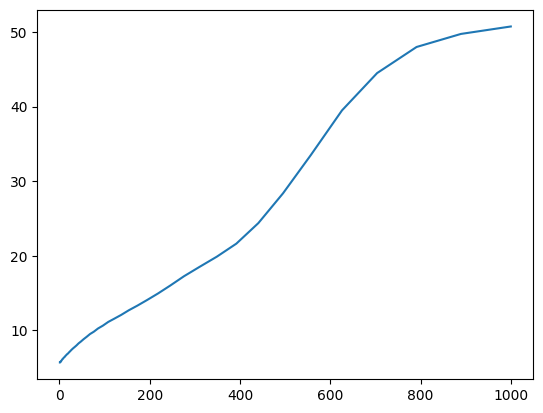

In [89]:
import matplotlib.pyplot as plt

plot_task = "country_capital"
feature = task_features[plot_task][0]

plt.plot(np.logspace(0, 3, 60), task_losses[plot_task][feature][0], label=f"{plot_task}: {feature}")
# plt.xscale("log")

In [61]:
task_losses[task_name][0]

[-3.484848484848485,
 -0.15656565656565657,
 -3.202020202020202,
 -0.3434343434343434,
 -0.7171717171717171,
 -0.2676767676767677,
 -0.696969696969697,
 -1.4646464646464648,
 -0.30303030303030304,
 -0.7070707070707071,
 -1.9090909090909092]

In [139]:
import plotly.express as px
import pandas as pd
import numpy as np

normalized_losses = {}

drop_features = [55186, 18719]
drop_ids = [features.index(feature) for feature in drop_features]

features_dropped = [feature for feature in features if feature not in drop_features]

for task_name, losses in negative_task_losses.items():
    base_loss = losses[1]
    losses = [x[0].tolist() for x in losses[0]]
    losses = np.array(losses)
    losses = np.delete(losses, drop_ids)

    losses = losses - base_loss[0]
    
    max_loss = np.max(losses)
    min_loss = np.min(losses)

    losses = (losses - min_loss) / (max_loss - min_loss)
    
    # mean_loss = np.mean(losses - base_loss)

    # base_acc = losses[1][1]

    # accs = [base_acc - loss[1] for loss in losses[0]]
    normalized_losses[task_name] = losses


heatmap = np.zeros((len(task_names), len(features_dropped)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features_dropped):
        heatmap[i, j] = normalized_losses[task_name][j]

heatmap /= np.mean(heatmap, axis=0, keepdims=True)



# heatmap = np.where(heatmap > 0, np.log(heatmap), -10)
# heatmap[np.isnan(heatmap)] = np.min(heatmap[np.isfinite(heatmap)])
# heatmap[np.isinf(heatmap)] = np.max(heatmap[np.isfinite(heatmap)])

# heatmap = np.clip(heatmap, -5, 5)


fig = px.imshow(heatmap, x=[str(x) for x in features_dropped], y=task_names)

fig.show()


: 

In [113]:
max_loss_features = {}

# heatmap[np.isnan(heatmap)] = 0

for i in range(heatmap.shape[0]):
    topk = np.argsort(heatmap[i])[-5:][::-1]
    max_loss_features[task_names[i]] = [features_dropped[j] for j in topk]

max_loss_features

{'location_continent': [2738, 3915, 19083, 26850, 8259],
 'football_player_position': [14975, 32092, 60969, 46677, 35008],
 'location_religion': [45893, 33364, 46677, 10818, 1461],
 'location_language': [23825, 56898, 3915, 19083, 8259],
 'person_profession': [8259, 1461, 18613, 3915, 26850],
 'location_country': [8259, 44111, 19083, 18613, 33364],
 'country_capital': [46357, 6417, 59236, 50241, 19083],
 'person_language': [50241, 18613, 33364, 1053, 1202],
 'singular_plural': [45455, 41300, 46677, 50241, 62079],
 'present_simple_past_simple': [18613, 3915, 47899, 35308, 46985],
 'antonyms': [5819, 17281, 3915, 50800, 8259],
 'plural_singular': [46677, 19083, 14975, 31409, 45455],
 'present_simple_past_perfect': [1461, 47899, 3915, 35308, 36806],
 'present_simple_gerund': [12295, 6417, 53000, 5819, 59236],
 'en_it': [19083, 62868, 56773, 3608, 3915],
 'it_en': [18613, 3915, 19083, 56170, 8300],
 'en_fr': [19083, 14975, 31409, 18613, 8259],
 'en_es': [18613, 50241, 12295, 56773, 62868],
 'fr_en': [19083, 3915, 46677, 36658, 62079],
 'es_en': [18613, 19083, 46677, 31409, 50241],
 'algo_last': [12295, 10818, 21375, 14975, 12284],
 'algo_first': [2738, 4036, 50241, 49334, 62868],
 'algo_second': [14975, 21375, 57215, 1053, 26850]}

In [47]:
import plotly.express as px
import pandas as pd
import numpy as np

normalized_losses = {}

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]
    mean_loss = np.mean(losses)

    normalized_losses[task_name] = [(loss - base_loss) / base_loss for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in normalized_losses.items()
    for feature, loss in zip(features, losses)
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = normalized_losses[task_name][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [39]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [73]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [75]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [77]:
import plotly.express as px
import pandas as pd
import numpy as np

for task_name, losses in task_losses.items():
    base_loss = losses[1]
    losses = losses[0]

    task_losses[task_name][0] = [(base_loss - loss) for loss in losses]


df = pd.DataFrame([
    {"task": task_name, "feature": feature, "loss": loss}
    for task_name, losses in task_losses.items()
    for feature, loss in zip(features, losses[0])
])



heatmap = np.zeros((len(task_names), len(features)))

for i, task_name in enumerate(task_names):
    for j, feature in enumerate(features):
        heatmap[i, j] = task_losses[task_name][0][j]

fig = px.imshow(heatmap, x=[str(x) for x in features], y=task_names)

fig.show()


In [46]:
feature = 11618

direction = sae["W_dec"][feature]


def steer_with_direction(direction, scale):
    direction = direction / jnp.linalg.norm(direction)
    direction = direction * scale
    add_act = make_act_adder(llama, direction, train_tokens, 12, sep=sep)

    logits = add_act(inputs)
    logits = logits.unwrap("batch", "seq", "vocabulary")

    return logprob_loss(logits, train_tokens, sep=sep, pad_token=pad, n_first=2)

In [38]:
import numpy as np
from tqdm.auto import tqdm

scales = np.linspace(0, 100, 30)

losses = [steer_with_direction(-direction, scale) for scale in tqdm(scales)]

  0%|          | 0/30 [00:00<?, ?it/s]

/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/dmitrii/.cache/pypoetry/virtualenvs/micrlhf-progress-_SD4q1c9-py3.10/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bfloat16 with jax_numpy_dtype_promot

[<matplotlib.lines.Line2D at 0x7f0b30b1ee90>]

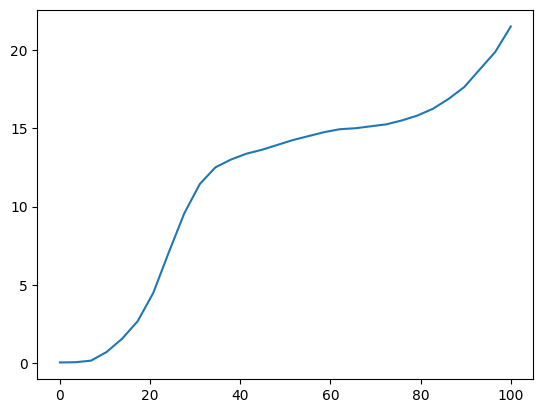

In [40]:
import matplotlib.pyplot as plt

losses = [x.tolist() for x in losses]

plt.plot(scales, losses)

In [47]:
losses_features = [steer_with_direction(-sae["W_dec"][feature], 30).tolist() for feature in tqdm(features)]

  0%|          | 0/11 [00:00<?, ?it/s]

In [42]:
losses_features

[3.65625,
 0.3046875,
 0.84765625,
 5.78125,
 8.1875,
 2.59375,
 11.0,
 7.03125,
 1.0390625,
 1.6640625,
 5.4375]

In [48]:
losses_features

[4.25,
 1.2578125,
 2.15625,
 4.84375,
 6.03125,
 3.84375,
 9.5625,
 6.8125,
 2.703125,
 2.90625,
 6.09375]

In [255]:
from tqdm.auto import tqdm
from functools import partial
from micrlhf.utils.activation_manipulation import add_vector

task_losses = {}

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "<start_of_turn>user\nFollow the pattern:\n{}"

task_name = "algo_first"

sep = 3978
pad = 0

pairs = list(tasks[task_name].items())

n_shot_losses = []

for n_shot in tqdm(range(2, 21)):
    runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

    tokenized = runner.get_tokens([
        x for x in runner.train_pairs
    ], tokenizer)

    inputs = tokenized_to_inputs(**tokenized)
    train_tokens = tokenized["input_ids"]

    logits, all_resids = get_resids_call(inputs)

    icl_loss = logprob_loss(
        logits.unwrap("batch", "seq", "vocabulary"), train_tokens, shift=0, n_first=3, sep=sep, pad_token=0
    )

    tokenized = runner.get_tokens(runner.eval_pairs, tokenizer)
    inputs = tokenized_to_inputs(**tokenized)
    tokens = tokenized["input_ids"]

    logits = llama(inputs)

    zero_loss = logprob_loss(
        logits.unwrap("batch", "seq", "vocabulary"), tokens, shift=0, n_first=3, sep=sep, pad_token=0
    )


    resids = all_resids[layer].value.unwrap(
        "batch", "seq", "embedding"
    )

    tv = get_tv(resids, train_tokens, shift = 0, sep=sep)

    add_act = make_act_adder(llama, tv.astype('bfloat16'), tokens, layer, length=1, shift= 0, sep=sep, scale=1)

    logits = add_act(inputs)

    tv_loss = logprob_loss(
        logits.unwrap("batch", "seq", "vocabulary"), tokens, shift=0, n_first=3, sep=sep, pad_token=0
    )


    arrow_pos = jnp.nonzero(tokens == sep)
    arrow_pos_single = []
    for i in range(runner.eval_batch_size):
        arrow_pos_single.append(arrow_pos[1][arrow_pos[0] == i].max())

    arrow_pos_single = np.array(arrow_pos_single)

    hits = 0

    logits = logits.unwrap("batch", "seq", "vocabulary")

    for i, (ap, l) in enumerate(zip(arrow_pos_single, logits)):
        l = l.argmax(-1)
        tgt = runner.eval_pairs[i][-1][1]
        hits += int(tgt in repr(tokenizer.decode(l[ap:ap+3])))


    n_shot_losses.append((icl_loss.tolist(), tv_loss.tolist(), hits / runner.eval_batch_size))

  0%|          | 0/19 [00:00<?, ?it/s]

In [184]:
logits = logits.unwrap("batch", "seq", "vocabulary")

In [248]:

arrow_pos = jnp.nonzero(tokens == sep)
arrow_pos_single = []
for i in range(batch_size):
    arrow_pos_single.append(arrow_pos[1][arrow_pos[0] == i].max())

arrow_pos_single = np.array(arrow_pos_single)

arrow_pos_single

array([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22],
      dtype=int32)

In [247]:
runner.eval_pairs

[[('student, close, wife, paper', 'student')],
 [('order, material, bill, start', 'order')],
 [('difference, problem, camera, in', 'difference')],
 [('show, talk, behind, section', 'show')],
 [('authority, king, share, personal', 'authority')],
 [('committee, candidate, university, give', 'committee')],
 [('truth, sell, bad, hard', 'truth')],
 [('statement, discussion, kind, war', 'statement')],
 [('tax, party, certainly, professor', 'tax')],
 [('exactly, department, push, officer', 'exactly')],
 [('minute, knowledge, get, price', 'minute')],
 [('everything, prepare, yet, purpose', 'everything')],
 [('case, force, small, project', 'case')],
 [('computer, case, road, opportunity', 'computer')],
 [('weapon, shoot, open, figure', 'weapon')],
 [('set, former, american, hold', 'set')],
 [('article, require, earth, impact', 'article')],
 [('affect, shit, respond, health', 'affect')],
 [('industry, i, serious, save', 'industry')],
 [('fine, memory, lot, term', 'fine')],
 [('discuss, whole, do, specific', 'discuss')],
 [('fail, try, raise, song', 'fail')],
 [('suggest, own, make, office', 'suggest')],
 [('society, morning, form, carry', 'society')],
 [('benefit, military, deal, state', 'benefit')],
 [('for, authority, experience, much', 'for')],
 [('light, brain, war, good', 'light')],
 [('identify, must, committee, speak', 'identify')],
 [('congress, legal, treat, next', 'congress')],
 [('rest, accept, theory, under', 'rest')],
 [('suggest, own, make, office', 'suggest')],
 [('simply, need, sign, long', 'simply')]]

In [236]:
for i, (ap, l) in enumerate(zip(arrow_pos_single, logits)):
    l = l.argmax(-1)
    tgt = runner.eval_pairs[i][-1][1]
    print(tgt, repr(tokenizer.decode(l[ap:ap+3])))

better ' better,\n\n'
book '  ,\n\n'
cut '  ,\n\n'
defense '  ,\n\n'
sign '  ,\n\n'
official '  ,\n\n'
artist ' artist,\n\n'
think ' think,\n\n'
south ' south,\n\n'
truth '  ,\n\n'
shit '  ,\n\n'
free ' economic,\n\n'
author '  ,\n\n'
see '  ,\n\n'
walk ' walk,\n\n'
job '  ,\n\n'


In [21]:
arrow_pos = jnp.nonzero(tokens == sep)[1]
arrow_pos

<jax.Array([31, 38, 35, 31, 35, 30, 38, 31, 30, 38, 35, 33, 31, 38, 27, 35],      dtype=int32)>

In [69]:
logits.argmax(-1)[0]

<jax.Array int32(256,) [≥1, ≤235_324] nonzero:256>

In [166]:
prompts = [runner.get_prompt(p) for p in runner.train_pairs]
print(prompts[0])

Follow the pattern:
car, war, have, death -> war
serious, go, understand, tree -> go
car, important, never, data -> important
president, face, word, color -> face
product, hold, lady, worker -> hold
sister, blood, too, bill -> blood
central, little, per, high -> little
energy, region, prawda, environment -> region
pick, value, brain, state -> value
floor, patient, attack, ask -> patient


In [253]:
runner.eval_pairs

[[('student, close, wife, paper', 'student')],
 [('order, material, bill, start', 'order')],
 [('difference, problem, camera, in', 'difference')],
 [('show, talk, behind, section', 'show')],
 [('authority, king, share, personal', 'authority')],
 [('committee, candidate, university, give', 'committee')],
 [('truth, sell, bad, hard', 'truth')],
 [('statement, discussion, kind, war', 'statement')],
 [('tax, party, certainly, professor', 'tax')],
 [('exactly, department, push, officer', 'exactly')],
 [('minute, knowledge, get, price', 'minute')],
 [('everything, prepare, yet, purpose', 'everything')],
 [('case, force, small, project', 'case')],
 [('computer, case, road, opportunity', 'computer')],
 [('weapon, shoot, open, figure', 'weapon')],
 [('set, former, american, hold', 'set')],
 [('article, require, earth, impact', 'article')],
 [('affect, shit, respond, health', 'affect')],
 [('industry, i, serious, save', 'industry')],
 [('fine, memory, lot, term', 'fine')],
 [('discuss, whole, do, specific', 'discuss')],
 [('fail, try, raise, song', 'fail')],
 [('suggest, own, make, office', 'suggest')],
 [('society, morning, form, carry', 'society')],
 [('benefit, military, deal, state', 'benefit')],
 [('for, authority, experience, much', 'for')],
 [('light, brain, war, good', 'light')],
 [('identify, must, committee, speak', 'identify')],
 [('congress, legal, treat, next', 'congress')],
 [('rest, accept, theory, under', 'rest')],
 [('suggest, own, make, office', 'suggest')],
 [('simply, need, sign, long', 'simply')]]

([<matplotlib.axis.XTick at 0x7f607138f790>,
  <matplotlib.axis.XTick at 0x7f607138c670>,
  <matplotlib.axis.XTick at 0x7f607138d270>,
  <matplotlib.axis.XTick at 0x7f607077c2e0>,
  <matplotlib.axis.XTick at 0x7f607077ca60>,
  <matplotlib.axis.XTick at 0x7f60704fc6a0>,
  <matplotlib.axis.XTick at 0x7f60a81b8250>,
  <matplotlib.axis.XTick at 0x7f607077d450>,
  <matplotlib.axis.XTick at 0x7f605158b2b0>,
  <matplotlib.axis.XTick at 0x7f6051589c90>,
  <matplotlib.axis.XTick at 0x7f60515891e0>,
  <matplotlib.axis.XTick at 0x7f605158afe0>,
  <matplotlib.axis.XTick at 0x7f605158b7c0>,
  <matplotlib.axis.XTick at 0x7f6051588af0>,
  <matplotlib.axis.XTick at 0x7f64d81340a0>,
  <matplotlib.axis.XTick at 0x7f605158be20>,
  <matplotlib.axis.XTick at 0x7f6071720b20>,
  <matplotlib.axis.XTick at 0x7f607169e620>,
  <matplotlib.axis.XTick at 0x7f605158a680>],
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9'),
  Text(8, 0, '10'),
  Text(9, 0, '11'),
  Text(10, 0, '12'),
  Text(11, 0, '13'),
  Text(12, 0, '14'),
  Text(13, 0, '15'),
  Text(14, 0, '16'),
  Text(15, 0, '17'),
  Text(16, 0, '18'),
  Text(17, 0, '19'),
  Text(18, 0, '20')])

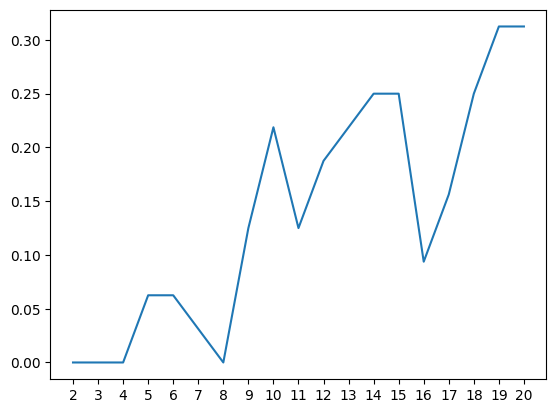

In [256]:
from matplotlib import pyplot as plt

plt.plot([x[2] for x in n_shot_losses])
plt.xticks(range(19), range(2, 21))
# plt.plot([x[1] for x in n_shot_losses])

In [202]:
list(zip(list(range(2, 18)), [x[2] for x in n_shot_losses]))

[(2, 0.0625),
 (3, 0.0),
 (4, 0.25),
 (5, 0.25),
 (6, 0.1875),
 (7, 0.25),
 (8, 0.25),
 (9, 0.5),
 (10, 0.125),
 (11, 0.375),
 (12, 0.3125),
 (13, 0.3125),
 (14, 0.625),
 (15, 0.6875),
 (16, 0.6875),
 (17, 0.25)]

In [13]:
from tqdm.auto import tqdm
from functools import partial
from micrlhf.utils.activation_manipulation import add_vector

from micrlhf.utils.ito import grad_pursuit


task_losses = {}

n_few_shots, batch_size, max_seq_len = 20, 16, 256
seed = 10

prompt = "<start_of_turn>user\nFollow the pattern:\n{}"

task_name = "algo_last"

sep = 3978
pad = 0

pairs = list(tasks[task_name].items())

n_shot_losses = []

n_shot = 15
runner = ICLRunner(task_name, pairs, batch_size=batch_size, n_shot=n_shot, max_seq_len=max_seq_len, seed=seed, prompt=prompt)

tokenized = runner.get_tokens([
    x for x in runner.train_pairs
], tokenizer)

inputs = tokenized_to_inputs(**tokenized)
train_tokens = tokenized["input_ids"]

logits, all_resids = get_resids_call(inputs)

icl_loss = logprob_loss(
    logits.unwrap("batch", "seq", "vocabulary"), train_tokens, shift=0, n_first=3, sep=sep, pad_token=0
)

tokenized = runner.get_tokens(runner.eval_pairs, tokenizer)
inputs = tokenized_to_inputs(**tokenized)
tokens = tokenized["input_ids"]

logits = llama(inputs)

zero_loss = logprob_loss(
    logits.unwrap("batch", "seq", "vocabulary"), tokens, shift=0, n_first=3, sep=sep, pad_token=0
)


resids = all_resids[layer].value.unwrap(
    "batch", "seq", "embedding"
)

tv = get_tv(resids, train_tokens, shift = 0, sep=sep)

add_act = make_act_adder(llama, tv.astype('bfloat16'), tokens, layer, length=1, shift= 0, sep=sep, scale=1)

logits = add_act(inputs)

tv_loss = logprob_loss(
    logits.unwrap("batch", "seq", "vocabulary"), tokens, shift=0, n_first=3, sep=sep, pad_token=0
)

gw, gtv = grad_pursuit(tv, sae["W_dec"], 20)

add_act = make_act_adder(llama, gtv.astype('bfloat16'), tokens, layer, length=1, shift= 0, sep=sep)

logits = add_act(inputs)

ito_loss = logprob_loss(
    logits.unwrap("batch", "seq", "vocabulary"), tokens, shift=0, n_first=3, sep=sep, pad_token=0
)

print(
    f"Grad pursuit TV: L: {layer}, Loss: {ito_loss}"
)



# arrow_pos = jnp.nonzero(tokens == sep)
# arrow_pos_single = []
# for i in range(batch_size):
#     arrow_pos_single.append(arrow_pos[1][arrow_pos[0] == i].max())

# arrow_pos_single = np.array(arrow_pos_single)

# hits = 0

# logits = logits.unwrap("batch", "seq", "vocabulary")

# for i, (ap, l) in enumerate(zip(arrow_pos_single, logits)):
#     l = l.argmax(-1)
#     tgt = runner.eval_pairs[i][-1][1]
#     hits += int(tgt in repr(tokenizer.decode(l[ap:ap+3])))

Grad pursuit TV: L: 18, Loss: 0.380859


In [14]:
jax.lax.top_k(gw, 10)

[# jax.Array float32(10,) ≈4.2e+01 ±3.2e+01 [≥2.3e+01, ≤1.4e+02] nonzero:10
   Array([135.43867 ,  41.27712 ,  37.228954,  36.440758,  33.29375 ,
           31.684303,  27.453093,  26.091726,  23.483995,  23.010355],      dtype=float32)
 ,
 # jax.Array int32(10,) [≥835, ≤15_693] nonzero:10
   Array([ 3851, 14456, 12802,  6356,  6179,   835,  8580,  8678, 12165,
          15693], dtype=int32)
 ]

In [230]:
hits/batch_size / 2

0.1875